# Making combined masks for histocytometry

Three approaches:

- Max of non-DAPI markers

- Sum of non-DAPI markers

- Binary gate of markers for each cell type

Using Mesmer_pypi conda environment (2023-05-16)

In [55]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import os

## Loading data

In [56]:
# img_path= "/stor/scratch/Ehrlich/Users/John/histocytometry/raw_images/40x_Cortex_DAPI_CD63_CD11c_Sirpa/image.tif"im
image_dir = "40x_Cortex_DAPI_CD63_CD11c_Sirpa"
image_name = "image.ome.tif"
preprocess_path = "/stor/scratch/Ehrlich/Users/John/histocytometry/processed_images/gb5"
img_path = os.path.join(preprocess_path, image_dir, image_name)

img = tifffile.imread(img_path)

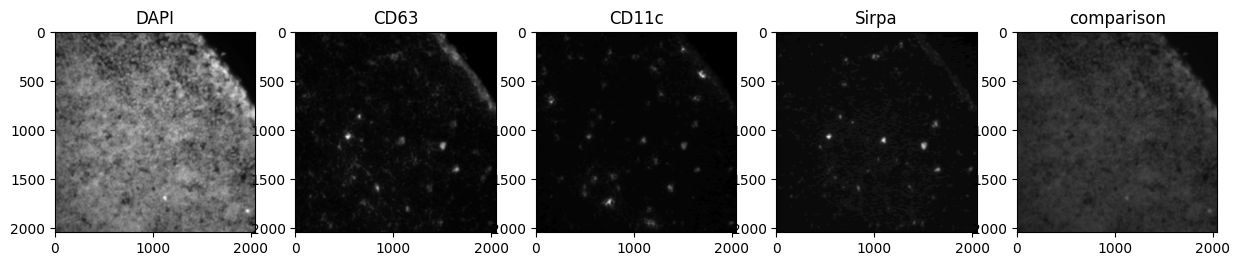

In [57]:
fig, ax = plt.subplots(1, 5, figsize=(15, 15))

plt.gray()
    ## matplotlib scales intensity by default to the range of pixel intensities, so these are not absolute value images.
ax[4].imshow(img[0, ...], vmin= 0, vmax= 255)

ax[0].imshow(img[0, ...])
ax[1].imshow(img[1, ...])
ax[2].imshow(img[2, ...])
ax[3].imshow(img[3, ...])

ax[0].set_title('DAPI')
ax[1].set_title('CD63')
ax[2].set_title('CD11c')
ax[3].set_title("Sirpa")
ax[4].set_title("comparison")
plt.show()

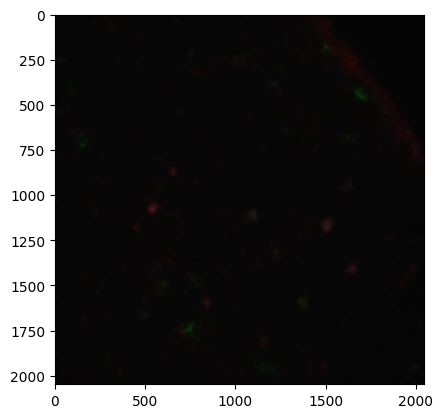

In [58]:
new_im_vec = img.swapaxes(0,2).swapaxes(0,1)
plt.imshow(new_im_vec[...,1:4])
plt.show()

The sum_mask is exactly how Mesmer works, so feeding these results into Mesmer as a single channel will yield the exact same results. 

## Max of non-DAPI markers

In [67]:
mem_marker_max = np.max(img[1:4,...], axis= 0)
mem_marker_max = mem_marker_max[np.newaxis, ...] 

max_mask = np.concatenate((img[0,np.newaxis, ...], mem_marker_max))

max_path= os.path.join(preprocess_path, image_dir, "max_membrane_mask")

if not os.path.exists(max_path):
    os.makedirs(max_path)

tifffile.imwrite(os.path.join(max_path, "image.tif"), max_mask)

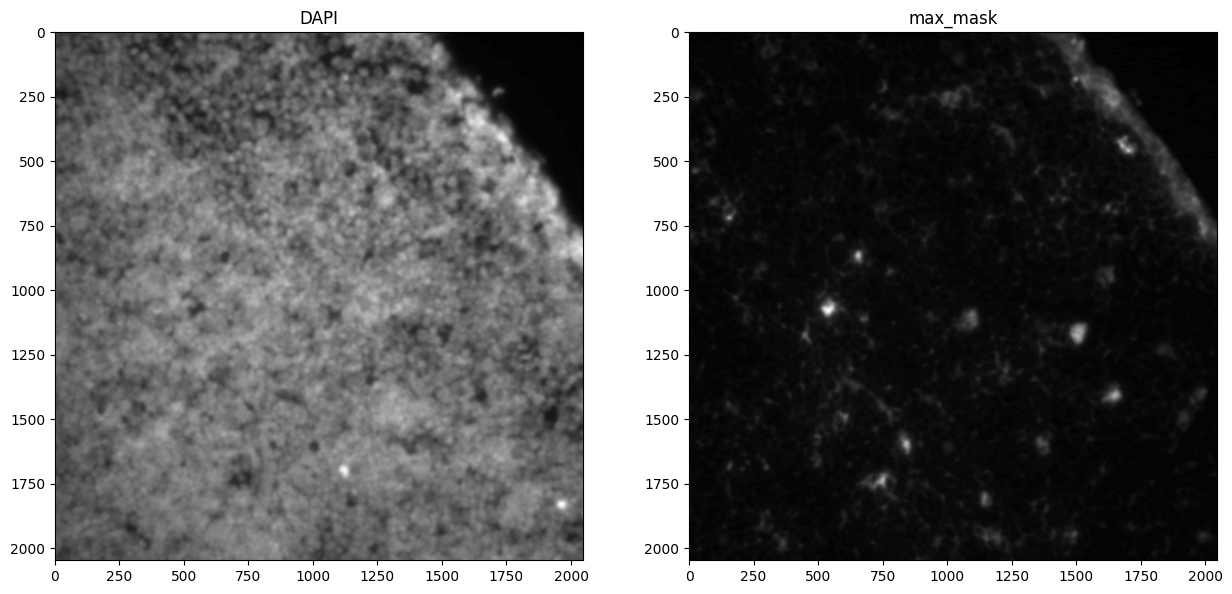

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(max_mask[0, ...])
ax[1].imshow(max_mask[1, ...])

ax[0].set_title('DAPI')
ax[1].set_title('max_mask')
plt.show()

## Binary gate for cell types

How should I establish the binary gate? What should I use for the threshold? I could just tinker with it. 

In [49]:
mem_marker_max = np.max(img[1:4,...], axis= 0)
mem_marker_max = mem_marker_max[np.newaxis, ...] 

## Lazy thresholding
threshold = 10
binary_mask = img > threshold
binary_mask = binary_mask.astype(np.uint8)

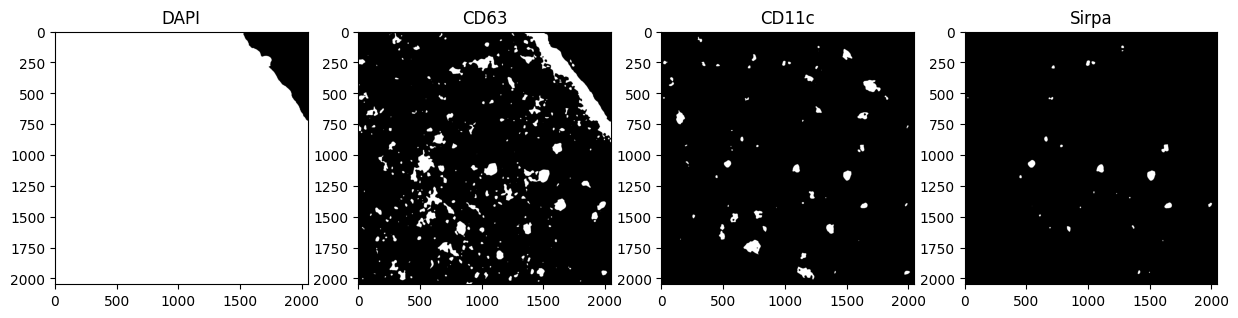

In [50]:
fig, ax = plt.subplots(1, 4, figsize=(15, 15))
ax[0].imshow(binary_mask[0, ...])
ax[1].imshow(binary_mask[1, ...])
ax[2].imshow(binary_mask[2, ...])
ax[3].imshow(binary_mask[3, ...])

ax[0].set_title('DAPI')
ax[1].set_title('CD63')
ax[2].set_title('CD11c')
ax[3].set_title("Sirpa")
plt.show()

### aDC2: Sirpa+ CD63+ CD11c_low (MerTK-)

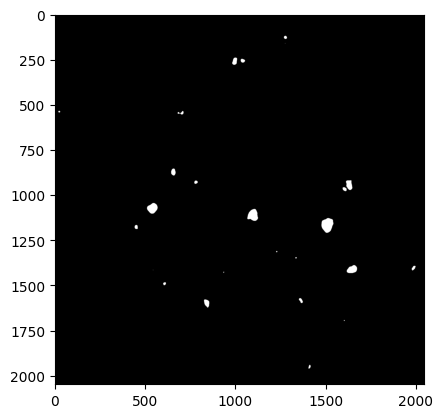

In [51]:
aDC2_mask = np.min(binary_mask, axis= 0)
plt.imshow(aDC2_mask)
plt.show()

### cDC2: Sirpa+ CD63- CD11c- (MerTK-)

In [52]:
binary_shape = binary_mask.shape[1:3]
cDC2_mask = np.zeros((binary_shape))
cDC2_array = np.array([0,0,1])

for row in range(binary_shape[0]):
    for col in range(binary_shape[1]):
        cDC2_mask[row, col] = np.all(binary_mask[1:4, row, col] == cDC2_array)

## I don't think this is the best way to do this, there has to be a vectorized approach. 

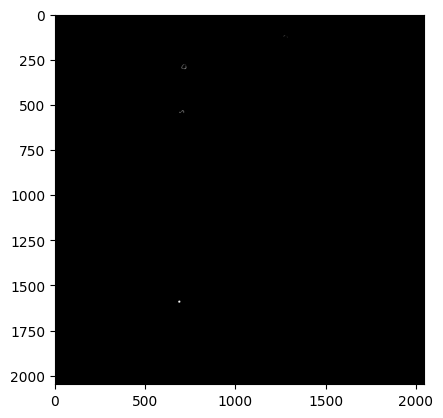

In [54]:
plt.imshow(cDC2_mask,  cmap= "gray")
plt.show()

plot_dir = "/stor/scratch/Ehrlich/Users/John/histocytometry/cell_type_masks/40x_Cortex_DAPI_CD63_CD11c_Sirpa"
tifffile.imwrite(os.path.join(plot_dir, "cDC2_binary_mask.tif"), cDC2_mask)
## I think this is right. It just doesn't look as good as I would hope. 

This image has clumps of pixels that match the cDC2 definition. I'm not sure if these overlay with the aDC2s. A gaussian blur might make it easier to find the overlapping areas of intensity. 

I tried the gaussian blur. It doesn't enable the binary mask to find the cDC2s. I think some of what I'm calling aDCs are cDC2s. 

I could take the max_mask of the gaussian blur and run that through the histocytometry pipeline. I can then call the cell types using scyan and see how many aDCs and cDCs I find.

I need to make this approach into a function that I can call on all of the images.